In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import math
import datetime as dt
from datetime import datetime
import time
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sodapy import Socrata
import warnings
warnings.filterwarnings("ignore")

# Machine learning libraries
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


# Investigate overall data

In [2]:
# Import data from API
client = Socrata('data.melbourne.vic.gov.au',
                 'rU9dviaJKpt9U9Mk9aPFFOIvS',
                 'khairul@yahoo.com',
                 'KhairulMaps2019&')
# To begin, download all data but limit to only for monday noons to get an overview
results = client.get("b2ak-trbp", day='Monday', time=12, limit=50000)
dfraw0 = pd.DataFrame.from_records(results)
display(dfraw0.shape)
display(dfraw0.head())

(17822, 10)

,date_time,day,hourly_counts,id,mdate,month,sensor_id,sensor_name,time,year
0,2019-11-04T12:00:00.000,Monday,4535,2891212,4,November,4,Town Hall (West),12,2019
1,2019-11-04T12:00:00.000,Monday,1145,2891213,4,November,17,Collins Place (South),12,2019
2,2019-11-04T12:00:00.000,Monday,421,2891214,4,November,18,Collins Place (North),12,2019
3,2019-11-04T12:00:00.000,Monday,2570,2891215,4,November,53,Collins St (North),12,2019
4,2019-11-04T12:00:00.000,Monday,5227,2891216,4,November,2,Bourke Street Mall (South),12,2019


In [3]:
# First round of cleaning
df = dfraw0.copy()
df['date_time'] = pd.to_datetime(df['date_time'])
df['date'] = df['date_time'].dt.date
df['year'] = df['year'].astype('int')
df['hourly_counts'] = df['hourly_counts'].astype('int')
df['sensor'] = df['sensor_id'].map(lambda row: '0'+str(row) if int(row)<10 else row) + " : " + df['sensor_name']
df['sensor_id'] = df['sensor_id'].astype('int')
df.dtypes

date_time        datetime64[ns]
day                      object
hourly_counts             int64
id                       object
mdate                    object
month                    object
sensor_id                 int64
sensor_name              object
time                     object
year                      int64
date                     object
sensor                   object
dtype: object

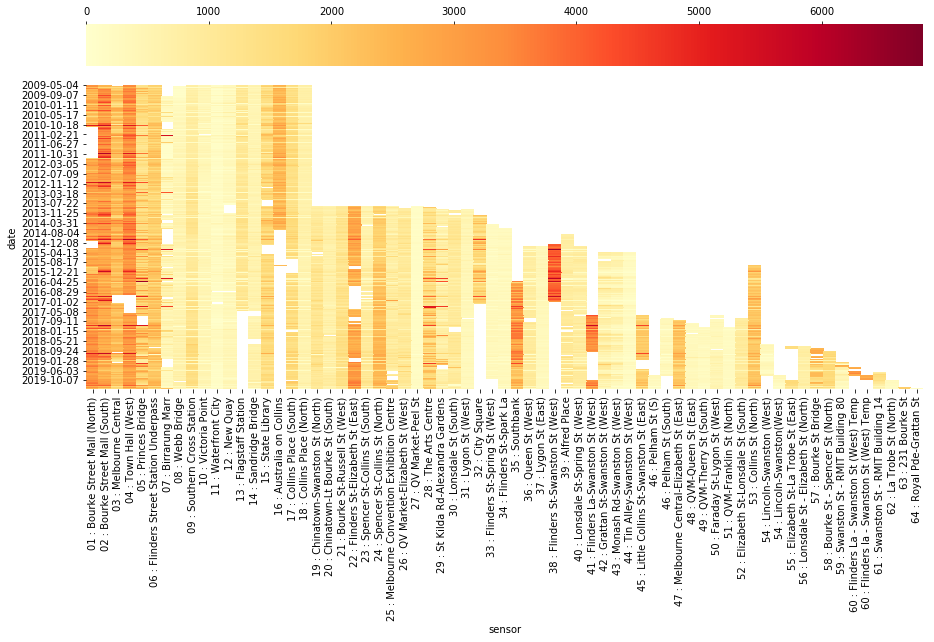

In [4]:
# Convert to pivot for plotting
table = pd.pivot_table(df, values='hourly_counts', index='date',
                       columns='sensor', aggfunc=np.sum)

# Plot all available data, sampling at Monday noon only
fig, ax = plt.subplots(figsize=(15,7))
ax = sns.heatmap(table, cbar_kws = dict(use_gridspec=False,location="top"), cmap='YlOrRd')
plt.show()

# Shortlist sensor locations and period

In [5]:
# Group sensor locations based on availability of data

sensor_master = pd.read_excel('files/CBD_grid.xlsx', sheet_name='master')
sensor_master = sensor_master.iloc[:,:6]
sensor_master.head()

,sensor_id,sensor_description,installation_date,CBD,Train_data,Test_data
0,1,Bourke Street Mall (North),2009-03-24,1,1,1
1,2,Bourke Street Mall (South),2009-03-30,1,1,1
2,3,Melbourne Central,2009-03-25,1,1,1
3,4,Town Hall (West),2009-03-23,1,1,1
4,5,Princes Bridge,2009-03-26,1,1,1


In [6]:
# List of sensor for training and test data
sensors = list(sensor_master[sensor_master['CBD']==1].sensor_id)
sensors_train_test = list(sensor_master[sensor_master['Train_data']==1].sensor_id)
sensors_test = list(sensor_master[(sensor_master['Train_data']==0)&sensor_master['Test_data']==1].sensor_id)
len(sensors)

36

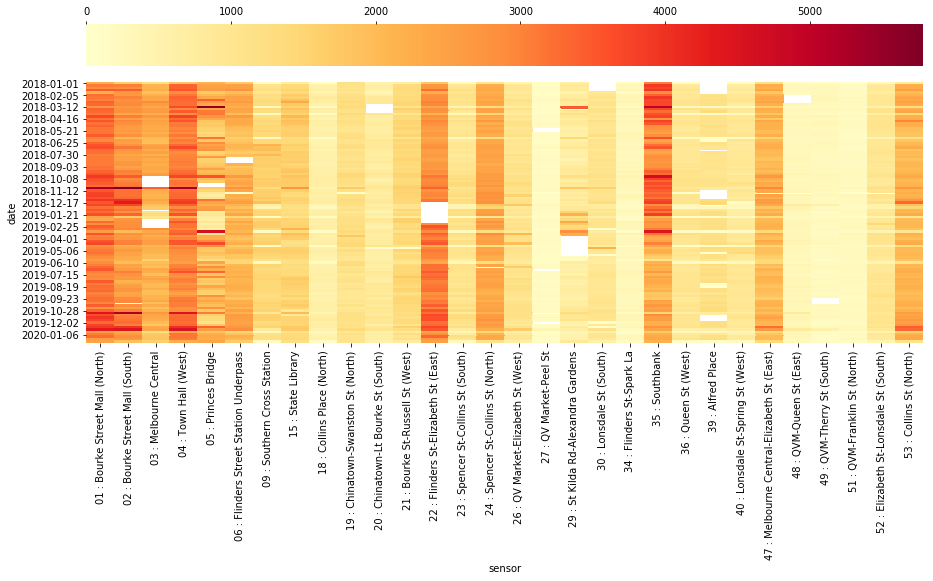

In [7]:
# Visualize training+test sensors for past 2 years
dftt = df[df['sensor_id'].isin(sensors_train_test)]
dfplot2 = dftt[dftt['year'] >= 2018][['date','sensor','hourly_counts']]

table2 = pd.pivot_table(dfplot2, values='hourly_counts', index='date',
                       columns='sensor', aggfunc=np.sum)

fig, ax = plt.subplots(figsize=(15,6))
ax = sns.heatmap(table2, cbar_kws = dict(use_gridspec=False,location="top"), cmap='YlOrRd')
plt.show()

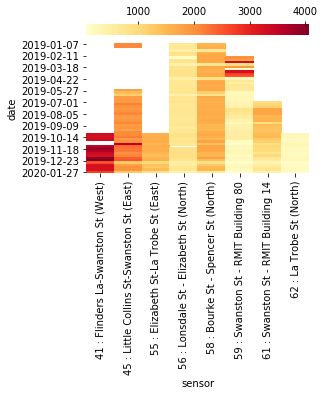

In [8]:
# Visualize test sensors only
dfts = df[df['sensor_id'].isin(sensors_test)]
table3 = pd.pivot_table(dfts[dfts['year'] >= 2019], values='hourly_counts', index='date',
                       columns='sensor', aggfunc=np.sum)

fig, ax = plt.subplots(figsize=(4,3))
ax = sns.heatmap(table3, cbar_kws = dict(use_gridspec=False,location="top"), cmap='YlOrRd')
plt.show()

In [9]:
# Download all data for shortlisted sensor for last 2 years

# pbar  = progressbar.ProgressBar()
# dfraw = pd.DataFrame(columns=dfraw0.columns)
# years = [2018, 2019, 2020]

# for year in years:
#     for sensor in sensors:
#         results = client.get("b2ak-trbp", sensor_id=sensor, year=year, limit=10000)
#         dfitem = pd.DataFrame.from_records(results)
#         dfraw = pd.concat([dfraw, dfitem])
# dfraw.to_csv('files/sensors_data.csv')
# len(dfraw)

In [10]:
# Open from saved API
dfraw = pd.read_csv('files/sensors_data.csv')
dfraw = dfraw.drop('Unnamed: 0', axis=1)

In [11]:
# Check if no missing datastamps 
a = len(dfraw.date_time.unique())
b = 2*365*24 + 31*24 # num of hours from 01-01-2018 to 31-01-2020
c = sorted(dfraw.date_time.unique())[-1]
print('Latest available timestamp in data: {c}'.format(c=c))
print('Number of unique timestamps in data: {a}'.format(a=a))
print('Number of expected timestamps: {b}'.format(b=b))
print('Missing timestamps: {d}'.format(d=b-a))

Latest available timestamp in data: 2020-01-31T23:00:00.000
Number of unique timestamps in data: 18264
Number of expected timestamps: 18264
Missing timestamps: 0


# Deal with missing (null) records

In [12]:
# Reshape df into pivot for filling nulls
df0 = dfraw[dfraw['sensor_id'].isin(sensors_train_test)] # exclude test-only sites
df0 = pd.pivot_table(df0, columns='sensor_id',
                     values='hourly_counts',
                     index=['date_time'],
                     aggfunc=np.sum)
display(df0.shape)

(18264, 30)

In [13]:
# Check the extent of nan values.
# Total records per sensor_id = 18,284
df0.isna().sum()

sensor_id
1      144
2      240
3     1570
4        0
5      264
6      433
9        0
15       0
18       0
19       0
20     792
21       0
22    1512
23       0
24      72
26      48
27     672
29    1634
30     600
34       0
35       0
36       0
39    2286
40       0
47     108
48     708
49     408
51       0
52     121
53       0
dtype: int64

In [14]:
# Since hourly traffic is very cyclical, copy value from
# the same time and the same day a week ago.

# Number of hours in a week
week_hrs = 7*24

for site in df0.columns:
    for row in range(len(df0.index)):
      # check if hourly record is null
        if math.isnan(df0[site].iloc[row]):
          # if so, copy from the same hour from a week ago
            if row - week_hrs > 0:
                df0[site].iloc[row] = df0[site].iloc[row - week_hrs]
            else:
                # if missing at start of the record:
                df0[site].iloc[row] = df0[site].iloc[row + week_hrs*6]

In [15]:
# Double check no nulls left
(df0.isna().sum()).sum()

0

In [16]:
# Unstack pivot to double check and prepare to build other columns

df0 = pd.DataFrame(df0.stack())
df0 = df0.rename(columns={0:'hourly_counts'})
df0 = df0.reset_index()
print('Number of complete timestamps: {b}'.format(b=b))
print('Number of df rows: {l1}'.format(l1=len(df0)))
print('Number df rows / timestamps = num of sites: {l2}'.format(l2=len(df0)/b))

Number of complete timestamps: 18264
Number of df rows: 547920
Number df rows / timestamps = num of sites: 30.0


In [17]:
# Build complete data frame
df = df0.copy()
df['date_time'] = pd.to_datetime(df['date_time']) # format='%Y-%m-%d %H:%M:%S'
df['time']      = df['date_time'].dt.hour
df['mdate']     = df['date_time'].dt.day
df['day']       = df['date_time'].dt.dayofweek
df['week']      = df['date_time'].dt.weekofyear
df['month']     = df['date_time'].dt.month
df['year']      = df['date_time'].dt.year
df['hourly_counts'] = df['hourly_counts'].astype('int')

names_table = sensor_master[['sensor_id', 'sensor_description']].set_index('sensor_id')
names_table = names_table.rename(columns={'sensor_description':'sensor_name'})
df = df.join(names_table, on='sensor_id')
df['sensor'] = (df['sensor_id'].map(lambda row: '0'+str(row)\
                                    if int(row)<10 else row)).astype('str')\
                                     + " : " + df['sensor_name']
display(len(df))
display(sorted(df.date_time.unique())[-1])
display(df.head(3))
display(df.dtypes)

547920

numpy.datetime64('2020-01-31T23:00:00.000000000')

,date_time,sensor_id,hourly_counts,time,mdate,day,week,month,year,sensor_name,sensor
0,2018-01-01,1,895,0,1,0,1,1,2018,Bourke Street Mall (North),01 : Bourke Street Mall (North)
1,2018-01-01,2,734,0,1,0,1,1,2018,Bourke Street Mall (South),02 : Bourke Street Mall (South)
2,2018-01-01,3,2996,0,1,0,1,1,2018,Melbourne Central,03 : Melbourne Central


date_time        datetime64[ns]
sensor_id                 int64
hourly_counts             int64
time                      int64
mdate                     int64
day                       int64
week                      int64
month                     int64
year                      int64
sensor_name              object
sensor                   object
dtype: object

# Investigate variations by location

## 1. Variation by traffic volume

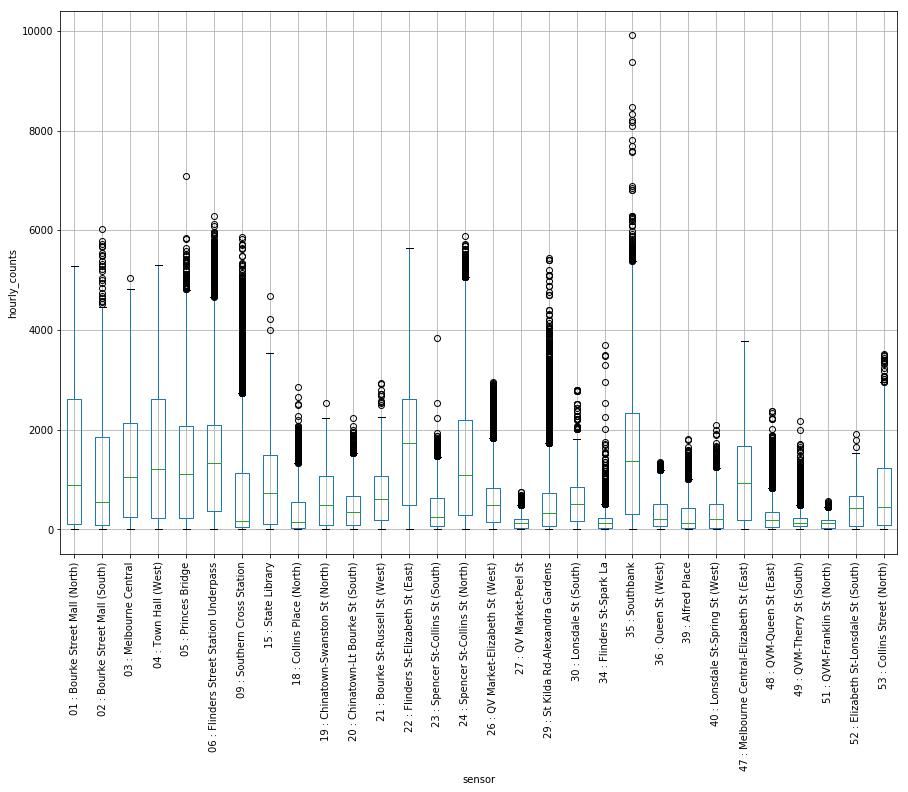

In [18]:
pivotvolume = pd.pivot_table(df, values='hourly_counts',
                             index='date_time', columns='sensor',
                             aggfunc=np.mean)
fig, ax = plt.subplots(figsize=(15,10))
pivotvolume.boxplot(ax=ax)
plt.xticks(rotation=90)
ax.set_xlabel('sensor')
ax.set_ylabel('hourly_counts')
plt.show()

## 2. Variation by period: hours, days, weeks

In [19]:
# Prepare data for variation by hour of the day (total)
pivothour = pd.pivot_table(df, values='hourly_counts', columns='day',
                           index='time', aggfunc=np.nanmean)
pivothour = preprocessing.normalize(pivothour, norm='l1', axis=0)
dfdays = pd.DataFrame(pivothour, index=range(0,24), columns=range(0,7))

# Prepare data for variation by hour of the day (weekday vs weekend)
weekdays = df[df['day'] < 5]
weekends = df[df['day'] > 4]
plot_data = []
for period in ['hours', 'days', 'week']:
    for total in [0,1]:
        cols_pivot = ['sensor_id'] if total==0 else None
        if period=='hours':
            for days in [1,0]:
                data = weekdays if days==1 else weekends
                pivothour  = pd.pivot_table(data, values='hourly_counts',
                                            index='time', columns=cols_pivot,
                                            aggfunc=np.nanmean)
                cols_hour = pivothour.columns
                pivothour = preprocessing.normalize(pivothour, norm='l1', axis=0)
                dfhour = pd.DataFrame(pivothour, index=range(0,24), columns=cols_hour)
                plot_data.append(dfhour)
        else:
            index_pivot = 'day' if period=='days' else 'week'
            index_df = range(0,7) if period=='days' else range(0,52)

            pivotweek = pd.pivot_table(df, values='hourly_counts',
                                       index=index_pivot, columns=cols_pivot,
                                       aggfunc=np.nanmean)
            cols_week = pivotweek.columns if total==0 else None
            pivotweek = preprocessing.normalize(pivotweek, norm='l1', axis=0)
            dfweek = pd.DataFrame(pivotweek, index=index_df, columns=cols_week)
            plot_data.append(dfweek)

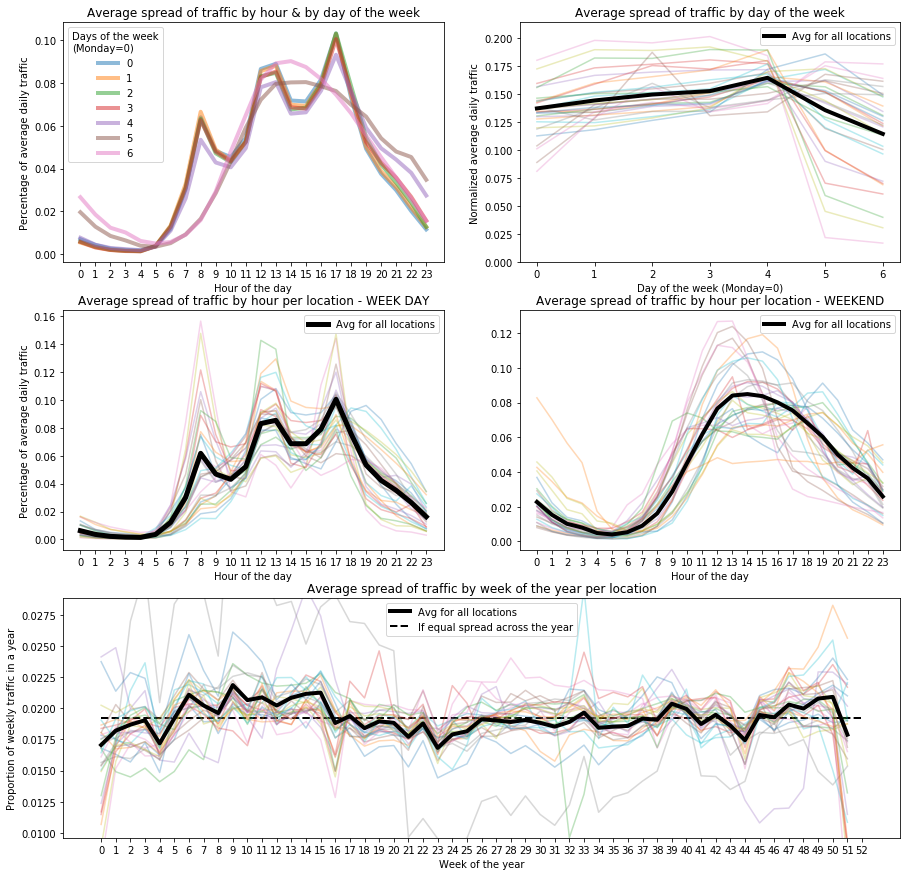

In [20]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(15,15))

ax[0,0].plot(dfdays, linewidth=4, alpha=0.5)
ax[0,0].set_title('Average spread of traffic by hour & by day of the week')
ax[0,0].set_ylabel('Percentage of average daily traffic')
ax[0,0].set_xlabel('Hour of the day')
ax[0,0].set_xticks(range(0,24))
ax[0,0].legend(dfdays.columns.values, title='Days of the week\n(Monday=0)')

# Plot variation by day of the week
ax[0,1].plot(plot_data[4], alpha=0.3)
ax[0,1].plot(plot_data[5], linewidth=4, c='black', label='Avg for all locations')
ax[0,1].set_title('Average spread of traffic by day of the week')
ax[0,1].set_ylabel('Normalized average daily traffic')
ax[0,1].set_ylim(0,1.5/7)
ax[0,1].set_xlabel('Day of the week (Monday=0)')
ax[0,1].legend()

# Plot variation by hour for weekdays
ax[1,0].plot(plot_data[0], alpha=0.3)
ax[1,0].plot(plot_data[2], linewidth=5, c='black', label='Avg for all locations')
ax[1,0].set_title('Average spread of traffic by hour per location - WEEK DAY')
# Plot variation by hour for weekends
ax[1,1].plot(plot_data[1], alpha=0.3)
ax[1,1].plot(plot_data[3], linewidth=4, c='black', label='Avg for all locations')
ax[1,1].set_title('Average spread of traffic by hour per location - WEEKEND')
ax[1,0].set_ylabel('Percentage of average daily traffic')
ax[1,0].set_xlabel('Hour of the day')
ax[1,1].set_xlabel('Hour of the day')
ax[1,0].set_xticks(range(0,24))
ax[1,1].set_xticks(range(0,24))
ax[1,0].legend()
ax[1,1].legend()

# Plot variation by week of the year
gs = ax[1, 1].get_gridspec()
for ax in ax[2,0:]:
    ax.remove()
axbig = fig.add_subplot(gs[2,0:])
axbig.plot(plot_data[6], alpha=0.3)
axbig.plot(plot_data[7], linewidth=4, c='black', label='Avg for all locations')
axbig.hlines(1/52,0,52,linestyles='dashed', linewidth=2, label='If equal spread across the year')
axbig.set_title('Average spread of traffic by week of the year per location')
axbig.set_ylim(0.5/52,1.5/52)
axbig.set_ylabel('Proportion of weekly traffic in a year')
axbig.set_xlabel('Week of the year')
axbig.set_xticks(range(0,53))
axbig.legend()
plt.show()

# Assign sites to groups

In [21]:
# Transform df to pivot such that columns are
# all possible combinations of day of week & time of day
pivotpca = pd.pivot_table(df, values='hourly_counts', index='sensor_id',
                          columns=['day','time'], aggfunc=np.mean)
sensor_id = pivotpca.index
# Normalize such that the sum of traffic in 7 days x 24 hours = 1
pivotpca = preprocessing.normalize(pivotpca, norm='l1', axis=1)
pivotpca = pd.DataFrame(pivotpca, index=sensor_id)
pivotpca.head()

,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,167
sensor_id,,,,,,,,,,,,,,,,,,,,,
1,0.000404,0.000266,0.000130,0.000105,0.000087,0.000164,0.000499,0.001445,0.003635,0.004319,...,0.014383,0.014358,0.013520,0.011833,0.009364,0.006186,0.003510,0.002380,0.001457,0.000784
2,0.000374,0.000228,0.000136,0.000115,0.000121,0.000139,0.000453,0.001327,0.003301,0.004340,...,0.014917,0.014952,0.013758,0.010527,0.006749,0.004000,0.002739,0.001848,0.001152,0.000644
3,0.001542,0.000915,0.000481,0.000358,0.000254,0.000375,0.000749,0.001589,0.003488,0.003548,...,0.010759,0.010663,0.010198,0.010423,0.010259,0.010071,0.008327,0.006413,0.004533,0.002694
4,0.000997,0.000640,0.000356,0.000282,0.000239,0.000377,0.000739,0.001883,0.004025,0.004629,...,0.012030,0.011797,0.011121,0.009891,0.008057,0.006649,0.005483,0.004234,0.002873,0.001645
5,0.000883,0.000528,0.000292,0.000251,0.000300,0.000557,0.001583,0.004057,0.007981,0.005784,...,0.012660,0.012174,0.011909,0.010532,0.008459,0.006992,0.005873,0.005022,0.003687,0.001894


[0.43087706 0.18982777 0.16061907 0.09539566 0.03471353]
87.7% of variance explained after 4 PCAs


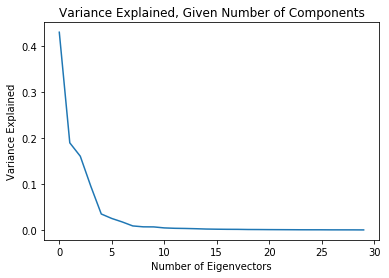

In [22]:
# Run PCA to help identify underlying traffic patterns per site

dfpca = StandardScaler().fit_transform(pivotpca)
fit = PCA()
pca = fit.fit_transform(dfpca)
plt.plot(fit.explained_variance_ratio_)
plt.title("Variance Explained, Given Number of Components")
plt.xlabel("Number of Eigenvectors")
plt.ylabel("Variance Explained")
k=4
print(fit.explained_variance_ratio_[:5])
print('{p}% of variance explained after {k} PCAs'.format(p=round(fit.explained_variance_ratio_[:k].sum()*100,1),k=k))

In [23]:
# Start building table from pca for plotting
dfpca = pd.DataFrame(pca[:, :4], index=pivotpca.index, columns=['pca1','pca2','pca3','pca4'])

# Append average hourly traffic per site
pivotavg = pd.pivot_table(df, values='hourly_counts', index='sensor_id', aggfunc=np.mean)
dfpca = dfpca.join(pivotavg, on='sensor_id')

# Append proportion of weekend traffic per site
pivotwkd = pd.pivot_table(df, values='hourly_counts', index='sensor_id', columns='day', aggfunc=np.mean)
pivotwkd['wkend_share'] = pivotwkd.iloc[:, -2:].sum(axis=1) / pivotwkd.iloc[:, :].sum(axis=1)
pivotwkd = pivotwkd['wkend_share']
dfpca = dfpca.join(pivotwkd, on='sensor_id')

# Append site names
dfpca = dfpca.join(names_table, on='sensor_id')
dfpca['sensor'] = (dfpca.index.map(lambda row: '0'+str(row)\
                                    if int(row)<10 else row)).astype('str')\
                                     + " : " + dfpca['sensor_name']

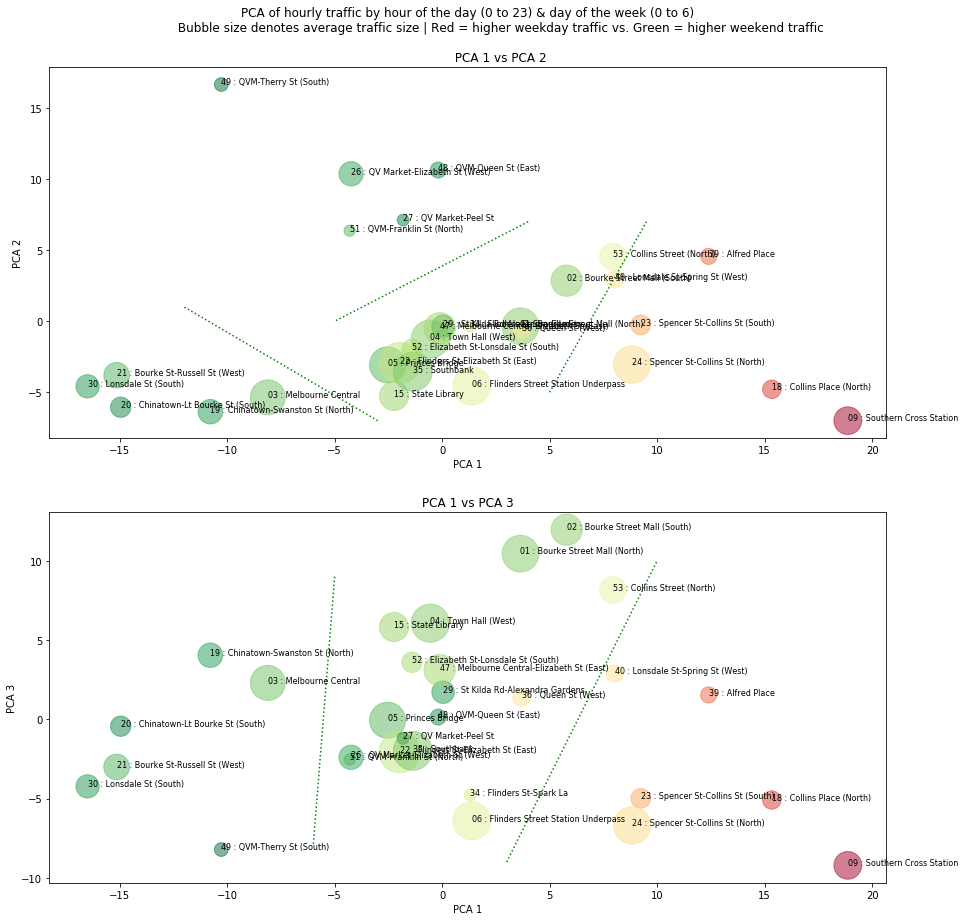

In [24]:
# Scatter plot to identify possible groupings of sites
fig, ax = plt.subplots(figsize=(15,15), ncols=1, nrows=2)
ax[0].set_title('PCA of hourly traffic by hour of the day (0 to 23) & day of the week (0 to 6)\n\
                 Bubble size denotes average traffic size | Red = higher weekday traffic vs. Green = higher weekend traffic\n\n\
                 PCA 1 vs PCA 2')
ax[1].set_title('PCA 1 vs PCA 3')

# Plot PCA 1 vs PCA 2
pcamap1 = ax[0].scatter(dfpca.pca1, dfpca.pca2, s=dfpca.hourly_counts,
                        c=dfpca.wkend_share, cmap='RdYlGn', alpha=0.5)
for i in range(len(dfpca.index)):
  ax[0].text(dfpca.iloc[i].pca1, dfpca.iloc[i].pca2, dfpca.iloc[i].sensor, fontsize=8)

# Plot PCA 1 vs PCA 3
pcamap2 = ax[1].scatter(dfpca.pca1, dfpca.pca3, s=dfpca.hourly_counts,
                        c=dfpca.wkend_share, cmap='RdYlGn', alpha=0.5)
for i in range(len(dfpca.index)):
  ax[1].text(dfpca.iloc[i].pca1, dfpca.iloc[i].pca3, dfpca.iloc[i].sensor, fontsize=8)

ax[0].set_xlabel('PCA 1')
ax[0].set_ylabel('PCA 2')
ax[1].set_xlabel('PCA 1')
ax[1].set_ylabel('PCA 3')
#fig.colorbar(pcamap1, orientation='horizontal', pad=0.05, shrink=0.3, ax=ax[1])

# Plot estimated grouping boundary for PCA 1 vs PCA 3
ax[0].plot((5,9.5), (-5,7), ls=':', c='g')
ax[0].plot((4,-5), (7,0), ls=':', c='g')
ax[0].plot((-3,-12), (-7,1), ls=':', c='g')

# Plot estimated grouping boundary for PCA 1 vs PCA 3
ax[1].plot((-5,-6), (9,-8), ls=':', c='g')
ax[1].plot((3,10), (-9,10), ls=':', c='g')

plt.show()

In [25]:
# # Visualize in 3D to get a full 3-way relationship
# import plotly.graph_objects as go
# fig = go.Figure(data=go.Scatter3d(x=dfpca.pca1, y=dfpca.pca2,z=dfpca.pca3,
#       text=dfpca.sensor, mode='markers', marker=dict(sizeref=20, size=dfpca.hourly_counts,
#       color = dfpca.wkend_share, colorscale = 'RdYlGn')))
# fig.update_layout(height=600, width=800, scene = dict(xaxis=dict(title='PCA 1'),
#                   yaxis=dict(title='PCA 2'), zaxis=dict(title='PCA 3')))
# fig.show()

In [26]:
# Identify number of groups
group_name = {1: 'Mixed-use sites',
              2: 'Business sites',
              3: 'Leisure sites'}

# Assign each site ID to a group
# in format {sensor_ID:group_name}
grouped_site = { 1:1,  2:1,  3:1,  4:1,  5:1,  6:1,  9:2, 15:1, 18:2, 19:1,
                20:1, 21:1, 22:1, 23:2, 24:2, 26:3, 27:3, 29:1, 30:1, 34:1,
                35:1, 36:1, 39:2, 40:2, 47:1, 48:3, 49:3, 51:3, 52:1, 53:1}

df['group'] = df['sensor_id'].map(grouped_site)

In [27]:
# Prepare data to plot variations by group:
weekdays = [0,1,2,3,4]
weekends = [5,6]
groups   = list(group_name.keys())
hour_data_list = []
day_data_list = []

for period in ['hours','days']:
    if period=='hours':
        for days in [weekdays, weekends]:
            for group in groups:
                for total in [0,1]:
                    data = df[(df['day'].isin(days)) & (df['group']==group)]
                    cols1 = 'sensor_id' if total==0 else None                
                    sites = pd.pivot_table(data, values='hourly_counts', index='time',
                                           columns=cols1, aggfunc=np.nanmean)
                    cols2 = sites.columns if total==0 else None
                    sites = preprocessing.normalize(sites, norm='l1', axis=0)
                    hour_data_sites = pd.DataFrame(sites, index=range(0,24), columns=cols2)
                    hour_data_list.append((hour_data_sites, group, days))
    else:
        for group in groups:
            for total in [0,1]:
                data = df[df['group']==group]
                cols1 = 'sensor_id' if total==0 else None                
                sites = pd.pivot_table(data, values='hourly_counts', index='day',
                                       columns=cols1, aggfunc=np.nanmean)
                cols2 = sites.columns if total==0 else None
                sites = preprocessing.normalize(sites, norm='l1', axis=0)
                day_data_sites = pd.DataFrame(sites, index=range(0,7), columns=cols2)
                day_data_list.append((day_data_sites, group))

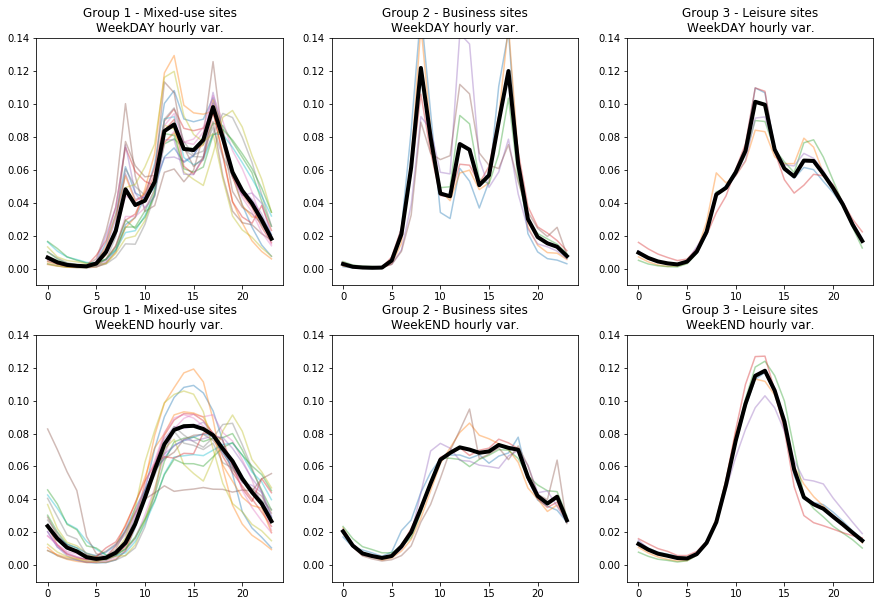

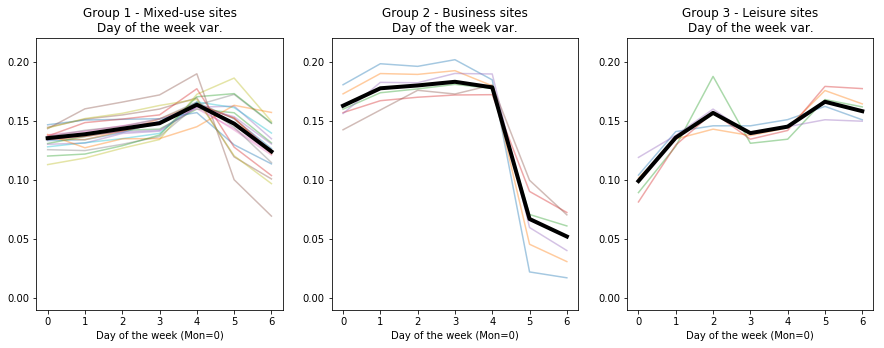

In [28]:
# Plot normalized hourly variation data
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15,10))
for i, ax in zip(list(range(0,len(hour_data_list),2)), axes.flat):
    ax.plot(hour_data_list[i][0], alpha=0.4)
    ax.plot(hour_data_list[i+1][0], linewidth=4, c='black')    
    ax.set_ylim(-0.01,0.14)
    wkday = 'WeekDAY' if len(hour_data_list[i][2]) > 2 else 'WeekEND'
    grp = hour_data_list[i][1]
    ax.set_title('Group {g1} - {g2}\n{w} hourly var.'.format(g1=grp, g2=group_name[grp],w=wkday))

# Plot normalized day of the week variation data
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,5))
for i, ax in zip(list(range(0,len(day_data_list),2)), axes.flat):
    ax.plot(day_data_list[i][0], alpha=0.4)
    ax.plot(day_data_list[i+1][0], linewidth=4, c='black')    
    ax.set_ylim(-0.01,0.22)
    ax.set_xlabel('Day of the week (Mon=0)')
    grp = hour_data_list[i][1]
    ax.set_title('Group {g1} - {g2}\nDay of the week var.'.format(g1=grp, g2=group_name[grp]))
plt.show()

In [29]:
# Aggregate similar sites together using group mean
# to formulate models by group instead of by invidual site.
# Mean is chosen in order to give more weight to sites with higher traffic.

dfs = df.copy()
dfs = dfs[['date_time', 'hourly_counts', 'group']]
dfs = pd.pivot_table(dfs, values='hourly_counts', index='date_time',
                     columns='group', aggfunc=np.mean)
dfs = dfs + 1 # for log transform
dfs.head(3)

group,1,2,3
date_time,,,
2018-01-01 00:00:00,1614.947368,729.333333,326.8
2018-01-01 01:00:00,1692.105263,412.833333,244.2
2018-01-01 02:00:00,979.421053,229.666667,129.2


# SARIMA model

### Train-test split

In [30]:
# Set train/test time split
data_start  = pd.to_datetime('2018010100', format='%Y%m%d%H', errors='ignore')
train_start = pd.to_datetime('2019080500', format='%Y%m%d%H', errors='ignore') # Mon midnight
one_week    = pd.Timedelta(hours=7*24)
train_end   = train_start + one_week * 3 # use 3 weeks of data as training
test_start  = train_end
test_end    = test_start + one_week      # 1 week of test data

# Assign train/test data frames
dfs_pre_test = dfs.loc[:train_end]
dfs_test     = dfs.loc[train_end:]

### Data decomposition & stationarity

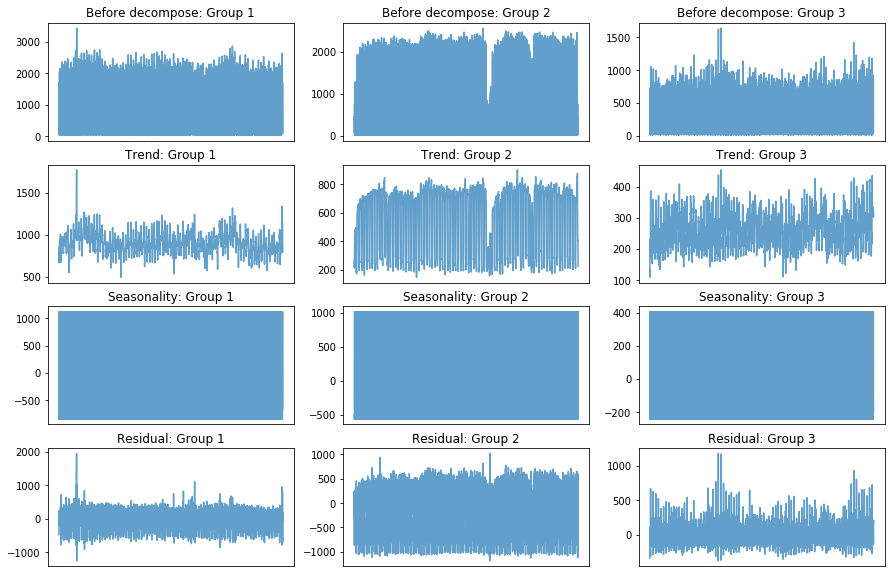

In [31]:
# Time series data composition per group
from statsmodels.tsa.seasonal import seasonal_decompose
groups = [1,2,3]
def decomp_list(dfs, groups):
    decomp, titles = [], []
    for group in groups:
        data = dfs_pre_test[group]
        d    = seasonal_decompose(data,model='additive')
        decomp.append(data)
        titles.append('Before decompose: Group {g}'.format(g=group))
        decomp.append(d.trend)
        titles.append('Trend: Group {g}'.format(g=group))
        decomp.append(d.seasonal)
        titles.append('Seasonality: Group {g}'.format(g=group))
        decomp.append(d.resid)
        titles.append('Residual: Group {g}'.format(g=group))
    return decomp, titles

decomp, titles = decomp_list(dfs, groups)
order = {0:0, 1:4, 2:8, 3:1, 4:5, 5:9, 6:2, 7:6, 8:10, 9:3, 10:7, 11:11}
fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(15,10))
for n, ax in zip(range(12), axes.flat):
    ax.plot(decomp[order[n]], alpha=0.7)
    ax.set_title(titles[order[n]], fontsize=12)
    ax.set_xticks([])
plt.show()

In [32]:
# TO BE REMOVED **********
# Analyse daily and weekly seasonal cycles for Group 1

# from statsmodels.tsa.seasonal import seasonal_decompose
# data   = dfs[1][train_start:train_end]
# daily  = seasonal_decompose(data, model='additive', freq=24)
# weekly = seasonal_decompose(data, model='additive', freq=24*7)
# adjusted = data - daily.seasonal - weekly.seasonal

# fig, axes = plt.subplots(ncols=1, nrows=4, figsize=(15,10))
# axes[0].plot(data)
# axes[1].plot(daily.seasonal)
# axes[2].plot(weekly.seasonal)
# axes[3].plot(adjusted)

# titles = ['Original', '24-period (daily) seasonal decompose',
#           '24x7-period (weekly) seasonal decompose', 'Original minus daily & weekly cycles']
# for title, ax in zip(titles, axes.flat):
#   ax.set_title(title)
#   ax.set_xticks([])
# plt.show()

In [33]:
# Calculate p-value of stationarity test over 1.5-year period

from statsmodels.tsa.stattools import adfuller
print('Verify stationarity using Dickey-Fuller test (p-value < 0.05):')
for group in groups:
    print('p-value for Group {g}: {af}'.format(g=group,af=adfuller(dfs_pre_test[group])[1]))

Verify stationarity using Dickey-Fuller test (p-value < 0.05):
p-value for Group 1: 1.6283625003593674e-21
p-value for Group 2: 2.6788254538253947e-30
p-value for Group 3: 3.247904873115661e-30


### Seasonal differencing

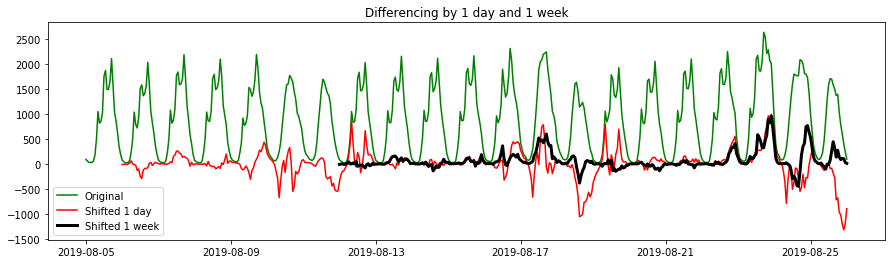

In [34]:
# Difference data by a day and by a week for Group 1
data = dfs[1][train_start:train_end]
data_shift_day  = data - data.shift(24)
data_shift_week = data - data.shift(24*7)
fig, ax = plt.subplots(figsize=(15,4))
plt.plot(data, c='green', label='Original')
plt.plot(data_shift_day,  c='red', label='Shifted 1 day')
plt.plot(data_shift_week, c='black', lw=3, label='Shifted 1 week')
ax.set_title('Differencing by 1 day and 1 week')
plt.legend()
plt.show()

### Autocorrelation (ACF) & Partial Autocorrelation (PACF)

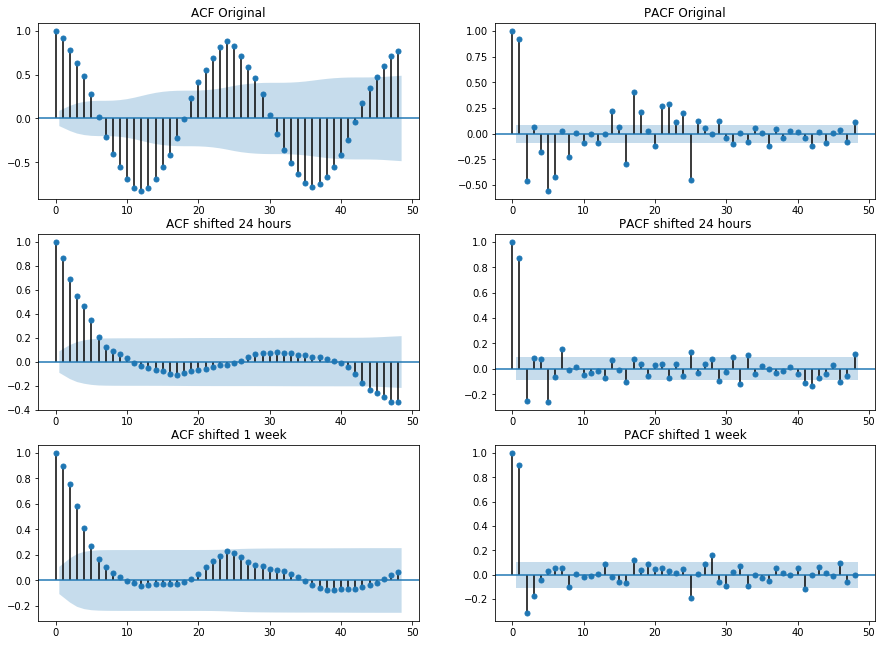

In [35]:
# Zoom in lags over 2 days
lags = 24*2 # hours

# Adjust time window since shifted data has null values at the start
data_shift_day_p  = data_shift_day[train_start + pd.Timedelta(hours=24):]
data_shift_week_p = data_shift_week[train_start + pd.Timedelta(hours=7*24):]

# Plot ACF & PCF
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(15,11))
plot_acf (data, lags=lags, ax=axes.flat[0], title='ACF Original')
plot_pacf(data, lags=lags, ax=axes.flat[1], title='PACF Original')
plot_acf (data_shift_day_p, lags=lags, ax=axes.flat[2], title='ACF shifted 24 hours')
plot_pacf(data_shift_day_p, lags=lags, ax=axes.flat[3], title='PACF shifted 24 hours')
plot_acf (data_shift_week_p, lags=lags, ax=axes.flat[4], title='ACF shifted 1 week')
plot_pacf(data_shift_week_p, lags=lags, ax=axes.flat[5], title='PACF shifted 1 week');

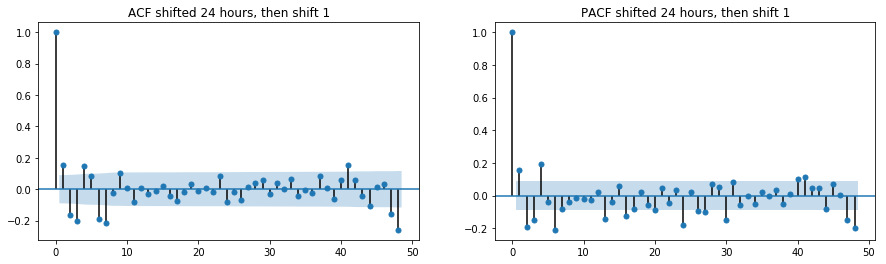

In [36]:
# Now shift the 24-hour shift by 1 since ACF is not decaying fast
data_shift_day1   = data_shift_day - data_shift_day.shift(1)
data_shift_day_p  = data_shift_day1[train_start + pd.Timedelta(hours=24+1):]

# Replot ACF & PCF
fig, axes = plt.subplots(ncols=2, figsize=(15,4))
plot_acf (data_shift_day_p, lags=lags, ax=axes.flat[0], title='ACF shifted 24 hours, then shift 1')
plot_pacf(data_shift_day_p, lags=lags, ax=axes.flat[1], title='PACF shifted 24 hours, then shift 1');

In [37]:
# Determine baseline SARIMA parameters from the latest ACF & PACF
# (24-hour shift, then 1 more shift)

p = 6  # lag from PACF
d = 1  # non-seasonal differences taken to get stationarity
q = 7  # lag from ACF
m = 24 # cycle repeats after 24 hours
P = 2  # 2 if in PACF 24 & 48 are significant
D = 1  # follows d
Q = 2  # 2 if in ACF 24 & 48 are significant

### Run baseline SARIMA model

In [38]:
# Select number of weeks to train
num_of_wks = 2
train_end = train_start + one_week * num_of_wks
data_arima = dfs[1][train_start : train_end]

In [39]:
# # Run SARIMA model using parameters from baseline above 
# start = time.time()
# print(f'Start: {(datetime.utcfromtimestamp(start).strftime("%H:%M:%S"))}')

# model = SARIMAX(data_arima, order=(p, d, q),
#                 seasonal_order=(P, D, Q, m)).fit()
# print(f'End: {datetime.utcfromtimestamp(time.time()).strftime("%H:%M:%S")} in {round((time.time()-start)/60,1)} minutes')

# # Pickle summary results
# filename = 'saved_models/pickle_sarima_base.sav'
# pickle.dump(model.summary(), open(filename, 'wb'))

In [40]:
# Open pickled baseline after training
filename = 'saved_models/pickle_sarima_base.sav'
baseline = pickle.load(open(filename, 'rb'))
print(baseline)

                                 Statespace Model Results                                 
Dep. Variable:                                  1   No. Observations:                  505
Model:             SARIMAX(6, 1, 7)x(2, 1, 2, 24)   Log Likelihood               -2926.610
Date:                            Fri, 21 Feb 2020   AIC                           5889.220
Time:                                    23:29:55   BIC                           5964.348
Sample:                                08-05-2019   HQIC                          5918.751
                                     - 08-26-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0773      0.344     -0.225      0.822      -0.751       0.597
ar.L2         -0.1866      0.172   

In [41]:
# Hyperparameter list to test
p_list = [6,7,13,16,17,20,24]
q_list = [6,7,8,9,10]
P_list = [1,2]
Q_list = [1,2]
d, D, m = 1, 1, 24

print('No of combinations: {c}'.format(c=len(p_list) * len(q_list) * len(P_list) * len(Q_list)))

num_of_wks = 2
train_end = train_start + one_week * num_of_wks
data_arima = dfs[1][train_start : train_end]

No of combinations: 140


In [42]:
# # Optimize hyperparameters for Group 1
# start = time.time()
# print(f'Start: {(datetime.utcfromtimestamp(start).strftime("%H:%M:%S"))}')

# # Iterate through hyperparam list to train SARIMA model
# sample_size = len(data_arima)
# results = []
# for p in p_list:
#   for q in q_list:
#     try:
#       model = SARIMAX(data_arima, order=(p, d, q), seasonal_order=(P, D, Q, m)).fit()
#     except:
#       continue
#     aic = model.aic
#     if aic < 1e10: # if fail to converge
#       best_aic = aic
#     results.append([p, d, q, P, D, Q, m, sample_size, round(aic,1)])

#   result_table = pd.DataFrame(results)
#   result_table.columns = ['p','d','q','P','D','Q','m','samples','AIC']
#   result_table = result_table.sort_values(by='AIC', ascending=True).reset_index(drop=True)
  
# print(f'End: {datetime.utcfromtimestamp(time.time()).strftime("%H:%M:%S")} in {round((time.time()-start)/60,1)} minutes')

# # Save result table in pickle
# filename = 'saved_models/pickle_sarima_optimization.sav'
# pickle.dump(result_table, open(filename, 'wb'))

In [43]:
# Open hyperparameter list from pickle
filename = 'saved_models/pickle_sarima_optimization.sav'
sarima_hyperparams = pickle.load(open(filename, 'rb'))
print('Top 3 hyperparameters from grid search sorted by AIC:')
display(sarima_hyperparams[:3])

Top 3 hyperparameters from grid search sorted by AIC:


,p,d,q,P,D,Q,m,samples,AIC
0,7,1,6,2,1,2,24,337,3810.3
1,6,1,6,2,1,2,24,337,3812.0
2,6,1,8,2,1,2,24,337,3813.2


In [44]:
num_of_wks = 3
train_end  = train_start + one_week * num_of_wks
data_arima = dfs[1][train_start : train_end]

# # Run SARIMA model with optimized parameters

# p,d,q,P,D,Q,m = sarima_hyperparams.iloc[0][:7].astype(int)
# model = SARIMAX(data_arima, order=(p, d, q), seasonal_order=(P, D, Q, m)).fit()

# # Pickle SARIMA trained model
# filename = 'saved_models/pickle_sarima.sav'
# pickle.dump(model, open(filename, 'wb'))

In [45]:
# Open pickled SARIMA after training
filename = 'saved_models/pickle_sarima.sav'
sarima = pickle.load(open(filename, 'rb'))
print(sarima.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       1   No. Observations:                  505
Model:             SARIMAX(7, 1, 6)x(2, 1, [1, 2], 24)   Log Likelihood               -2925.327
Date:                                 Thu, 27 Feb 2020   AIC                           5886.654
Time:                                         10:51:28   BIC                           5961.782
Sample:                                     08-05-2019   HQIC                          5916.185
                                          - 08-26-2019                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2613      0.437     -0.598      0.550      -1.118       0

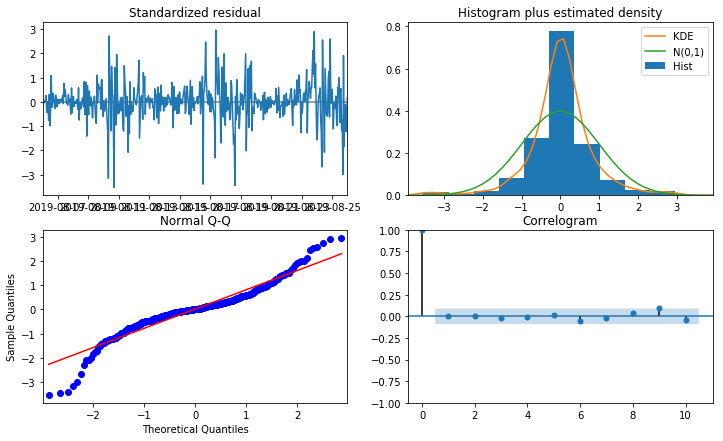

In [46]:
# Check assumptions of SARIMA model results
sarima.plot_diagnostics(figsize=(12,7));

In [47]:
# Assign periods for plotting
plot_start = train_end - one_week # only show final week
test_start = train_end
test_end   = test_start + one_week

data_train = dfs[1][plot_start : train_end]
data_test  = dfs[1][test_start : test_end]

# Generate prediction and confidence interval
pred = sarima.predict(start=test_start, end=test_end, dynamic=True)
pred_conf = sarima.get_forecast(168).conf_int()

In [48]:
display(plot_start, train_end, test_start, test_end)

Timestamp('2019-08-19 00:00:00')

Timestamp('2019-08-26 00:00:00')

Timestamp('2019-08-26 00:00:00')

Timestamp('2019-09-02 00:00:00')

In [49]:
data_arima[-1:]

date_time
2019-08-26    98.105263
Name: 1, dtype: float64

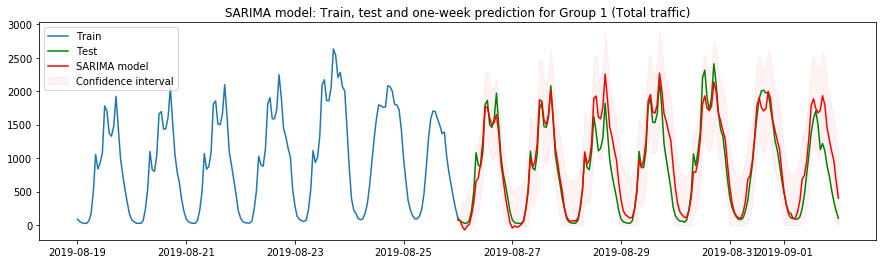

In [50]:
# Visualize train, test and prediction

fig, ax = plt.subplots(figsize=(15,4))
plt.plot(data_train, label='Train')
plt.plot(data_test, label='Test', c='g')
plt.plot(pred, label='SARIMA model', c='r')
plt.fill_between(pred_conf.index, pred_conf['upper 1'],
                 pred_conf['lower 1'].clip(0), color='r', alpha=.05,
                 label='Confidence interval');
plt.legend(loc='upper left')
ax.set_title('SARIMA model: Train, test and one-week prediction for Group 1 (Total traffic)')
plt.show()

### SARIMA - with MinMax scaled input

In [51]:
num_of_wks = 3
data_arima_unscaled = dfs[1][train_start : train_start + one_week * num_of_wks]

# Select source
source = data_arima_unscaled

# Fit and transform for model input - WITH MIN MAX
scaler = MinMaxScaler()
scaler.fit(np.array(source).reshape(-1, 1))

data_arima = scaler.transform(np.array(source).reshape(-1, 1)).ravel()
data_arima = pd.DataFrame(data_arima, index=source.index)

In [52]:
# # Fit model using scaled data
# model = SARIMAX(data_arima, order=(p, d, q), seasonal_order=(P, D, Q, m)).fit()

# # Pickle SARIMA trained model
# filename = 'saved_models/pickle_sarima_scaled.sav'
# pickle.dump(model, open(filename, 'wb'))

In [53]:
# Open from pickle
filename = 'saved_models/pickle_sarima_scaled.sav'
sarima_scaled = pickle.load(open(filename, 'rb'))

# Predict
pred_scaled = sarima_scaled.predict(start=test_start, end=test_end, dynamic=True)
pred_conf_scaled = sarima_scaled.get_forecast(len(pred_scaled)).conf_int()

# Inverse transform prediction
pred2 = scaler.inverse_transform(np.array(pred_scaled).reshape(-1, 1))
pred2 = pd.DataFrame(pred2, index=pred_scaled.index).clip(0)

# Inverse transform confidence interval
pred_conf2 = scaler.inverse_transform(pred_conf_scaled)
pred_conf2 = pd.DataFrame(pred_conf2, index=pred_scaled.index, columns=['upper','lower']).clip(0)

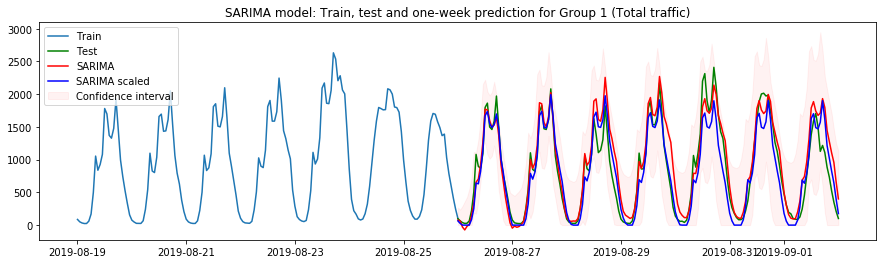

In [54]:
fig, ax = plt.subplots(figsize=(15,4))
plt.plot(data_train, label='Train')
plt.plot(data_test, label='Test', c='g')
plt.plot(pred, label='SARIMA', c='r')
plt.plot(pred2, label='SARIMA scaled', c='blue')
plt.fill_between(pred_conf2.index, pred_conf2['upper'],
                 pred_conf2['lower'], color='r', alpha=.05,
                 label='Confidence interval');
plt.legend(loc='upper left')
ax.set_title('SARIMA model: Train, test and one-week prediction for Group 1 (Total traffic)')
plt.show()

### SARIMA - with Standard Scaled input

In [55]:
num_of_wks = 3
data_arima_unscaled = dfs[1][train_start : train_start + one_week * num_of_wks]

# Select source
source = data_arima_unscaled

# Fit and transform for model input - WITH STANDARD SCALER
scaler =StandardScaler()
scaler.fit(np.array(source).reshape(-1, 1))

data_arima = scaler.transform(np.array(source).reshape(-1, 1)).ravel()
data_arima = pd.DataFrame(data_arima, index=source.index)

In [56]:
# # Fit model using scaled data
# model = SARIMAX(data_arima, order=(p, d, q), seasonal_order=(P, D, Q, m)).fit()

# # Pickle SARIMA trained model
# filename = 'saved_models/pickle_sarima_std_scaled.sav'
# pickle.dump(model, open(filename, 'wb'))

In [57]:
# Open from pickle
filename = 'saved_models/pickle_sarima_std_scaled.sav'
sarima_scaled = pickle.load(open(filename, 'rb'))

# Predict
pred_scaled = sarima_scaled.predict(start=test_start, end=test_end, dynamic=True)
pred_conf_scaled = sarima_scaled.get_forecast(len(pred_scaled)).conf_int()

# Inverse transform prediction
pred2 = scaler.inverse_transform(np.array(pred_scaled).reshape(-1, 1))
pred2 = pd.DataFrame(pred2, index=pred_scaled.index).clip(0)

# Inverse transform confidence interval
pred_conf2 = scaler.inverse_transform(pred_conf_scaled)
pred_conf2 = pd.DataFrame(pred_conf2, index=pred_scaled.index, columns=['upper','lower']).clip(0)

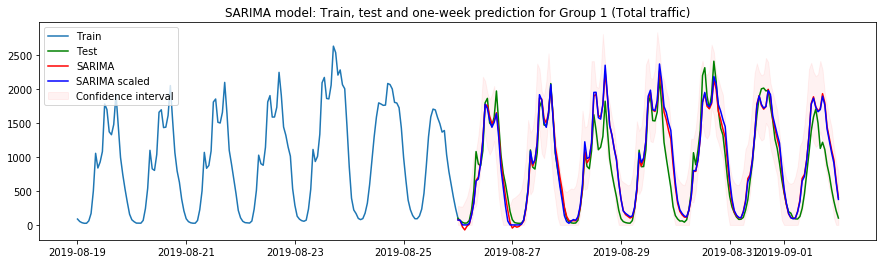

In [58]:
fig, ax = plt.subplots(figsize=(15,4))
plt.plot(data_train, label='Train')
plt.plot(data_test, label='Test', c='g')
plt.plot(pred, label='SARIMA', c='r')
plt.plot(pred2, label='SARIMA scaled', c='blue')
plt.fill_between(pred_conf2.index, pred_conf2['upper'],
                 pred_conf2['lower'], color='r', alpha=.05,
                 label='Confidence interval');
plt.legend(loc='upper left')
ax.set_title('SARIMA model: Train, test and one-week prediction for Group 1 (Total traffic)')
plt.show()

### Apply MinMax scaled model to Sensor #52

In [59]:
# Assign periods for plotting
start      = train_start + one_week * 2
train_end = start + one_week
test_start = train_end
test_end   = test_start + one_week
num_of_wks = 3

In [60]:
# Generic model for a given group
# Open from pickle (general model)
filename = 'saved_models/pickle_sarima_scaled.sav' # trained with MinMax
sarima_scaled = pickle.load(open(filename, 'rb'))

# Predict (general model) - do once
pred_scaled = sarima_scaled.predict(start=test_start, end=test_end, dynamic=True)

# Predict confidence interval (general model) - do once
pred_conf = sarima_scaled.get_forecast(len(pred_scaled)).conf_int()

In [61]:
# Pivot all data by site
dfsite = df.copy()
dfsite = dfsite[['date_time', 'hourly_counts', 'sensor_id']]
dfsite = pd.pivot_table(dfsite, values='hourly_counts', index='date_time',
                      columns='sensor_id', aggfunc=np.mean)

In [62]:
# Data for individual sensor. This can be looped for all sites later.

# Group:1, sensor_id:1, name: Elizabeth-Lonsdale
lonsdale = dfsite[52] # ID=52

# For data scaling
lonsdale_scaling = lonsdale[train_start : train_start + one_week * num_of_wks]

# For plotting
lonsdale_train = lonsdale[start : train_end]
lonsdale_test  = lonsdale[test_start : test_end]

In [63]:
# Fit to Elizabeth-Lonsdale data
scaler = MinMaxScaler()
scaler = scaler.fit(np.array(lonsdale_scaling).reshape(-1, 1))

# Prediction: Inverse transform for Elizabeth-Lonsdale fit scaler
pred3 = scaler.inverse_transform(np.array(pred_scaled).reshape(-1, 1))
pred3 = pd.DataFrame(pred3, index=data_test.index).clip(0)

# Confidence interval: Inverse transform for Elizabeth-Lonsdale fit scaler
pred3c = scaler.inverse_transform(pred_conf)
pred3c = pd.DataFrame(pred3c, index=pred3.index, columns=['upper','lower']).clip(0)

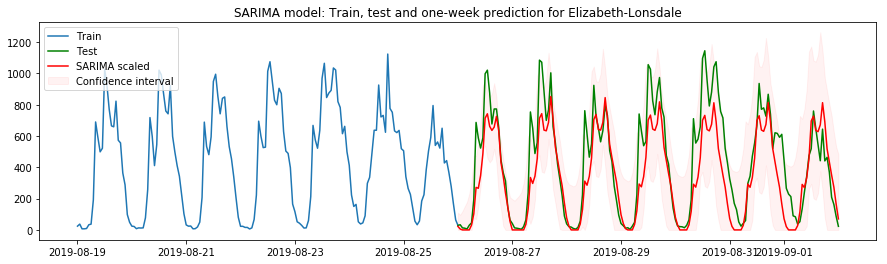

In [64]:
fig, ax = plt.subplots(figsize=(15,4))
plt.plot(lonsdale_train, label='Train')
plt.plot(lonsdale_test, label='Test', c='g')
plt.plot(pred3, label='SARIMA scaled', c='r')
plt.fill_between(pred3c.index, pred3c['upper'],
                 pred3c['lower'], color='r', alpha=.05,
                 label='Confidence interval');
plt.legend(loc='upper left')
ax.set_title('SARIMA model: Train, test and one-week prediction for Elizabeth-Lonsdale')
plt.show()

### Apply Standard scaled model to Sensor #52

In [65]:
# Assign periods for plotting
start      = train_start + one_week * 2
train_end = start + one_week
test_start = train_end
test_end   = test_start + one_week
num_of_wks = 3

In [66]:
# Generic model for a given group
# Open from pickle (general model)
filename = 'saved_models/pickle_sarima_std_scaled.sav' # trained with StandardScaler
sarima_scaled = pickle.load(open(filename, 'rb'))

# Predict (general model) - do once
pred_scaled = sarima_scaled.predict(start=test_start, end=test_end, dynamic=True)

# Predict confidence interval (general model) - do once
pred_conf = sarima_scaled.get_forecast(len(pred_scaled)).conf_int()

In [67]:
# Pivot all data by site
dfsite = df.copy()
dfsite = dfsite[['date_time', 'hourly_counts', 'sensor_id']]
dfsite = pd.pivot_table(dfsite, values='hourly_counts', index='date_time',
                      columns='sensor_id', aggfunc=np.mean)

In [68]:
# Data for individual sensor. This can be looped for all sites later.

# Group:1, sensor_id:1, name: Elizabeth-Lonsdale
lonsdale = dfsite[52] # ID=52

# For data scaling
lonsdale_scaling = lonsdale[train_start : train_start + one_week * num_of_wks]

# For plotting
lonsdale_train = lonsdale[start : train_end]
lonsdale_test  = lonsdale[test_start : test_end]

In [69]:
# Fit to Elizabeth-Lonsdale data
scaler = MinMaxScaler()
scaler = scaler.fit(np.array(lonsdale_scaling).reshape(-1, 1))

# Prediction: Inverse transform for Elizabeth-Lonsdale fit scaler
pred3 = scaler.inverse_transform(np.array(pred_scaled).reshape(-1, 1))
pred3 = pd.DataFrame(pred3, index=data_test.index).clip(0)

# Confidence interval: Inverse transform for Elizabeth-Lonsdale fit scaler
pred3c = scaler.inverse_transform(pred_conf)
pred3c = pd.DataFrame(pred3c, index=pred3.index, columns=['upper','lower']).clip(0)

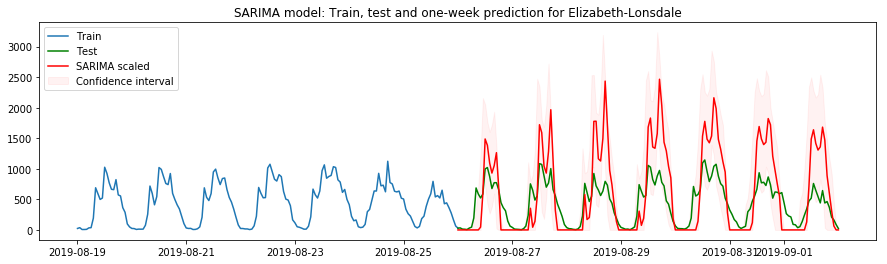

In [70]:
fig, ax = plt.subplots(figsize=(15,4))
plt.plot(lonsdale_train, label='Train')
plt.plot(lonsdale_test, label='Test', c='g')
plt.plot(pred3, label='SARIMA scaled', c='r')
plt.fill_between(pred3c.index, pred3c['upper'],
                 pred3c['lower'], color='r', alpha=.05,
                 label='Confidence interval');
plt.legend(loc='upper left')
ax.set_title('SARIMA model: Train, test and one-week prediction for Elizabeth-Lonsdale')
plt.show()

# Neural network - LSTM

### Train/test split

In [71]:
# Set train/test time split
train_start  = pd.to_datetime('2018010100', format='%Y%m%d%H', errors='ignore') 
train_end    = pd.to_datetime('2019083123', format='%Y%m%d%H', errors='ignore')
test_start   = train_end  + pd.Timedelta(hours=1)
test_end     = pd.to_datetime('2020013123', format='%Y%m%d%H', errors='ignore')

# Assign train/test data frames
dfn = dfs.copy()
dfn_train = dfn.loc[train_start:train_end]
dfn_test  = dfn.loc[test_start:]
print('Test/train ratio: {r}'.format(r=round(len(dfn_test)/(len(dfn_train)+len(dfn_test)),2)))

Test/train ratio: 0.2


### Scale and assign to groups

In [72]:
# Scale and assign each group separately
scaler = MinMaxScaler()
# Group 1
scaler.fit(np.array(dfn_train[1]).reshape(-1,1))
df1_train = (scaler.transform(np.array(dfn_train[1]).reshape(-1,1))).ravel()
df1_test  = (scaler.transform(np.array(dfn_test[1]).reshape(-1,1))).ravel()
# Group 2
scaler.fit(np.array(dfn_train[2]).reshape(-1,1))
df2_train = (scaler.transform(np.array(dfn_train[2]).reshape(-1,1))).ravel()
df2_test  = (scaler.transform(np.array(dfn_test[2]).reshape(-1,1))).ravel()
# Group 2
scaler.fit(np.array(dfn_train[3]).reshape(-1,1))
df3_train = (scaler.transform(np.array(dfn_train[3]).reshape(-1,1))).ravel()
df3_test  = (scaler.transform(np.array(dfn_test[3]).reshape(-1,1))).ravel()
# Show train & test sample
display(df1_train.shape, df1_test.shape)

(14592,)

(3672,)

### Set up and compile neural network

In [73]:
# Function to split time series data into:
#   n consecutive time steps of data as X
#   and 1 time step of data as y

import numpy as np
def split_data(data, n_steps):
    X, y = list(), list()
    for i in range(len(data)):
        # index of last element for each grouping of steps
        end_ix = i + n_steps
    # break condition at the end of the sequence
        if end_ix > len(data)-1:
            break
        # X = first n elements, y = the element after
        seq_x, seq_y = data[i:end_ix], data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [74]:
import warnings
warnings.filterwarnings("ignore")

In [75]:
# Assign number of time steps & epochs
# n_steps = n sequence of X in time series followed by one Y
n_steps    = 24*7*4 # 4 weeks worth of hourly input to predict 1 future hour
batch_size = 24*7
epochs     = 10
n_features = 1

# Reshape X from [samples, steps] into [samples, steps, features]
# as the required Keras input format
X_train, y_train = split_data(df1_train, n_steps)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test, y_test = split_data(df1_test, n_steps)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

# Assign hyperparameters for model
cells1 = 64
cells2 = 64
activ1 = 'relu'
activ2 = 'relu'
optimizer='adam'
loss='mse'
metrics=['mse', 'mae', 'mape', 'cosine']

# Define and fit model
model = Sequential()
model.add(LSTM(cells1, activation=activ1, input_shape=(n_steps, n_features),
               return_sequences=True))
model.add(LSTM(cells1, activation=activ1,
               return_sequences=True))
model.add(LSTM(cells1, activation=activ1,
               return_sequences=True))
model.add(LSTM(cells2, activation=activ2))
model.add(Dense(1))

In [76]:
# # Train model
# model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
# history = model.fit(X_train, y_train, epochs=epochs,
#                      batch_size=batch_size, verbose=1,
#                      validation_data=(X_test, y_test))

# # Pickle results
# filename = 'saved_models/pickle_lstm_base_model.sav'
# pickle.dump(model, open(filename, 'wb'))
# filename = 'saved_models/pickle_lstm_base_history.sav'
# pickle.dump(history, open(filename, 'wb'))

### Evaluate baseline results

In [77]:
# Open baseline from pickle
filename = 'saved_models/pickle_lstm_base_model.sav'
model = pickle.load(open(filename, 'rb'))
filename = 'saved_models/pickle_lstm_base_history.sav'
history = pickle.load(open(filename, 'rb'))

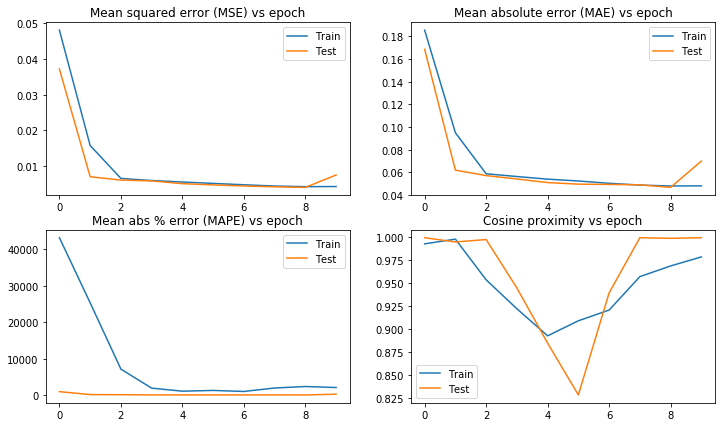

In [78]:
# Plot metrics vs num of epochs
metrics=['mse', 'mae', 'mape', 'cosine']
titles =['Mean squared error (MSE) vs epoch', 'Mean absolute error (MAE) vs epoch',
         'Mean abs % error (MAPE) vs epoch', 'Cosine proximity vs epoch']

fig, axes = plt.subplots(2,2, figsize=(12,7))
for i, ax in zip(range(len(metrics)), axes.flat):
    ax.plot(history.history[metrics[i]], label='Train')
    ax.plot(history.history['val_{metrics}'.format(metrics=metrics[i])], label='Test')
    ax.set_title(titles[i])
    ax.legend()
plt.show()

### Prediction using baseline

In [79]:
# Assign input data to be fed to prediction
source = df1_train
input_set, target = split_data(source, n_steps)

# Select the number of days to be predicted beyond the last data in source
future_days  = 7
future_hours = 24 * future_days

# Select only records at the end
prediction_source = input_set[:-future_hours]

# # Run prediction for future_hours and store
# prediction_output = []
# for i in range(future_hours):
#     prediction_input = prediction_source[i].reshape((1, n_steps, n_features))
#     prediction = model.predict(prediction_input).ravel()[0]
#     prediction_output.append(prediction)
    
# # Pickle results
# filename = 'saved_models/pickle_lstm_base_predict1.sav'
# pickle.dump(prediction_output, open(filename, 'wb'))

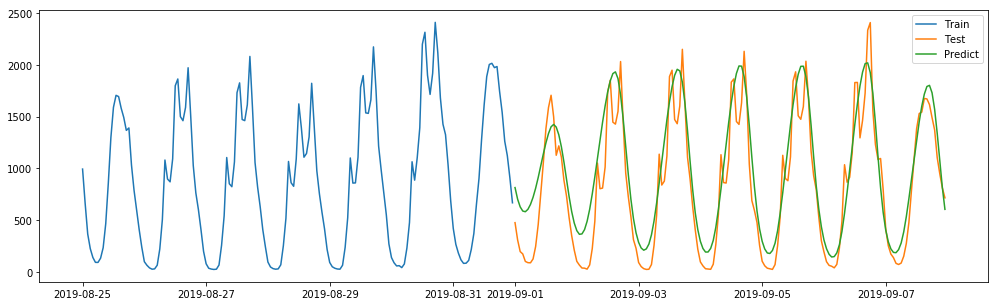

In [80]:
# Open from pickle
filename = 'saved_models/pickle_lstm_base_predict1.sav'
prediction_output = pickle.load(open(filename, 'rb'))

# Scaler for total Group 1
scaler = MinMaxScaler()
scaler.fit(np.array(dfn_train[1]).reshape(-1,1))

# Inverse transform and assign to dataframe
pred = scaler.inverse_transform(np.array(prediction_output).reshape(-1, 1))
df_pred = pd.DataFrame(pred, index=dfn_test[1][:future_hours].index)

# Plot train, test and predict
fig, ax = plt.subplots(figsize=(17,5))
plt.plot(dfn_train[1][-(24*7):], label='Train')
plt.plot(dfn_test[1][:future_hours], label='Test')
plt.plot(df_pred, label='Predict')
plt.legend()
plt.show()

### Redo prediction mechanism

In [81]:
# Test hour n=0:
# Input0  = final n_steps (24 x 7 x 4) hours of data from training set
# Output0 = predict(Input0)

# Test hour n=1:
# Input1  = Input1 excluding the final n=1 hour
#           + Output0
# Output1 = predict(Input1)

# Test hour n=2:
# Input2  = Input1 excluding the final n=2 hours
#           + Output0
#           + Output1
# Output2 = predict(Input2)

# Repeat until Test hour n = 24 x 7 = future period that we're interested in

In [82]:
# # Select pickled model to use for prediction
# filename = 'saved_models/pickle_lstm_base_model4.sav'
# model = pickle.load(open(filename, 'rb'))
# # Set n_steps to match params used in pickled model (if different)
# n_steps = 24*7*8

# # Select the number of days to be predicted beyond the last data in source
# future_days  = 7
# future_hours = 24 * future_days

# # Initialize input with final train sequence
# final_train = df1_train[-n_steps:]

# # Run prediction for future_hours and store
# prediction_output = []
# test = []
# input = final_train
# for i in range(future_hours):
#     prediction = model.predict(input.reshape((1, n_steps, n_features)))
#     prediction_output.append(prediction.ravel()[0])
#     # Updated input = train input excluding final n + first n predictions
#     input = np.append(final_train[(i+1):], prediction_output[:(i+1)])
    
# # Pickle prediction
# filename = 'saved_models/pickle_lstm_base_predict1_recalc4.sav'
# pickle.dump(prediction_output, open(filename, 'wb'))

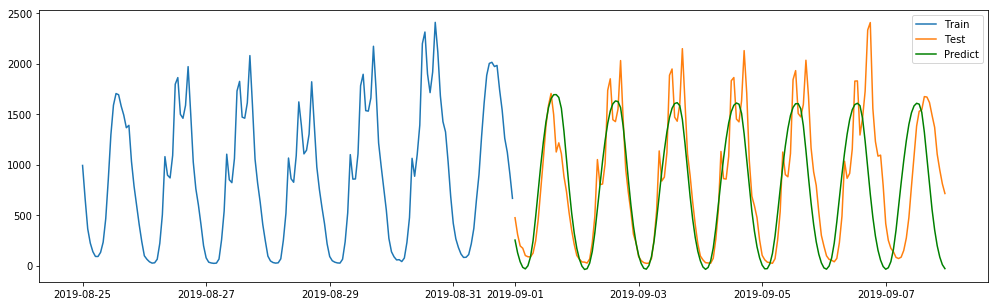

In [83]:
# Open from pickle (OLD)
filename = 'saved_models/pickle_lstm_base_predict1.sav'
prediction_output0 = pickle.load(open(filename, 'rb'))

# Open from pickle (NEW)
filename = 'saved_models/pickle_lstm_base_predict1_recalc4.sav'
prediction_output = pickle.load(open(filename, 'rb'))

# Scaler for total Group 1
scaler = MinMaxScaler()
scaler.fit(np.array(dfn_train[1]).reshape(-1,1))

# Inverse transform and assign to dataframe (OLD)
pred0 = scaler.inverse_transform(np.array(prediction_output0).reshape(-1, 1))
df_pred0 = pd.DataFrame(pred0, index=dfn_test[1][:future_hours].index)

# Inverse transform and assign to dataframe (NEW)
pred = scaler.inverse_transform(np.array(prediction_output).reshape(-1, 1))
df_pred = pd.DataFrame(pred, index=dfn_test[1][:future_hours].index)

# Plot train, test and predict
fig, ax = plt.subplots(figsize=(17,5))
plt.plot(dfn_train[1][-(24*7):], label='Train')
plt.plot(dfn_test[1][:future_hours], label='Test')
#plt.plot(df_pred0, label='Predict OLD', c='g', ls='dashed')
plt.plot(df_pred, label='Predict', c='g')
plt.legend()
plt.show()

# To do list

~~**EDA**~~
1. ~~Narrow down sites and period~~
2. ~~Variation by high/low traffic sites~~
3. ~~Variation by hour / day of week / seasons~~

~~**Cleansing**~~
1. ~~Verify no missing timestamp~~
2. ~~Fill nulls based on general variation rule~~

~~**Assign sites to groups**~~
1. ~~Run PCA to get better insight on possible groupings~~
2. ~~Combine PCA with EDA info to decide on groupings~~
3. ~~Drop more sites if needed / restate outliers if needed~~

**Baseline model - SARIMA**
1. ~~Train/test split~~
2. ~~Stationarity~~
3. ~~Differencing~~
4. ~~PACF, ACF~~
5. ~~Select p, d, q~~
6. ~~Select P, D, Q, m seasonality~~
7. ~~Hyperparameters grid search~~
8. ~~Predict at total level~~
9. ~~Predict at individual site level~~
10. ~~Difference using minmax vs standard scaler~~
11. **Any way to fix standard scaler at site level?**
12. **Repeat for Groups 2 & 3**
13. **Hyperparams optimization**
14. **Train all sites individually**


**Enhanced model 1 - LSTM**
1. ~~Train/test split~~
2. ~~Set up a working LSTM network~~
3. ~~Run baseline Group 1~~
4. ~~Predict at total level~~
6. ~~Redo the start/end date to match SARIMA dates~~
7. ~~Fix moving input prediction calculation method~~
8. Hyperparameters grid search & n_steps

**Enhanced model 2 - new ideas?**
1. Emulate SARIMA as linear regression

**Visualisation for end users**
1. Static heatmap on city centre map
2. Variable heatmap animation
3. Variable hourly plot animation
4. Web app
